In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    init_channel = 256
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/3))), 
                          strides=1, padding='same', activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 256)        1536      
_________________________________________________________________
flatten (Flatten)            (None, 4096000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 4096000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                65536016  
Total params: 65,537,552
Trainable params: 65,537,552
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 256)         0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 256)         327936    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 256)         0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 128)         163968    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 128)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8214 - acc: 0.4150
Epoch 00001: val_loss improved from inf to 1.34747, saving model to model/checkpoint/1D_CNN_custom_4_DO_4_conv_checkpoint/001-1.3475.hdf5
36805/36805 [==============================] - 273s 7ms/sample - loss: 1.8215 - acc: 0.4150 - val_loss: 1.3475 - val_acc: 0.5761
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1908 - acc: 0.6319
Epoch 00002: val_loss improved from 1.34747 to 1.07798, saving model to model/checkpoint/1D_CNN_custom_4_DO_4_conv_checkpoint/002-1.0780.hdf5
36805/36805 [==============================] - 271s 7ms/sample - loss: 1.1909 - acc: 0.6319 - val_loss: 1.0780 - val_acc: 0.6648
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9457 - acc: 0.7145
Epoch 00003: val_loss improved from 1.07798 to 0.96347, saving model to model

36800/36805 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9827
Epoch 00028: val_loss did not improve from 0.89372
36805/36805 [==============================] - 272s 7ms/sample - loss: 0.0611 - acc: 0.9827 - val_loss: 1.4880 - val_acc: 0.7480
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.9823
Epoch 00029: val_loss did not improve from 0.89372
36805/36805 [==============================] - 272s 7ms/sample - loss: 0.0633 - acc: 0.9823 - val_loss: 1.4677 - val_acc: 0.7487
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0604 - acc: 0.9833
Epoch 00030: val_loss did not improve from 0.89372
36805/36805 [==============================] - 271s 7ms/sample - loss: 0.0603 - acc: 0.9833 - val_loss: 1.4990 - val_acc: 0.7556
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9829
Epoch 00031: val_loss did not improve from 0.89372
36805/36805 [=====================

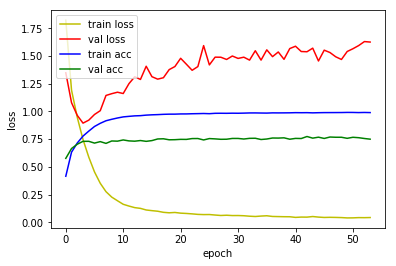

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.9750 - acc: 0.6982
Loss: 0.9750270652251081 Accuracy: 0.6982347

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9735 - acc: 0.3572
Epoch 00001: val_loss improved from inf to 1.42455, saving model to model/checkpoint/1D_CNN_custom_4_DO_5_conv_checkpoint/001-1.4245.hdf5
36805/36805 [==============================] - 277s 8ms/sample - loss: 1.9734 - acc: 0.3572 - val_loss: 1.4245 - val_acc: 0.5770
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2880 - acc: 0.5965
Epoch 00002: val_loss improved from 1.42455 to 1.05952, saving model to model/checkpoint/1D_CNN_custom_4_DO_5_conv_checkpoint/002-1.0595.hdf5
36805/36805 [==============================] - 275s 7ms/sample - loss: 1.2880 - acc: 0.5965 - val_loss: 1.0595 - val_acc: 0.6788
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0365 - ac

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1120 - acc: 0.9644
Epoch 00027: val_loss did not improve from 0.62539
36805/36805 [==============================] - 276s 7ms/sample - loss: 0.1120 - acc: 0.9644 - val_loss: 0.7823 - val_acc: 0.8409
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9661
Epoch 00028: val_loss did not improve from 0.62539
36805/36805 [==============================] - 276s 7ms/sample - loss: 0.1088 - acc: 0.9661 - val_loss: 0.8628 - val_acc: 0.8223
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1056 - acc: 0.9669
Epoch 00029: val_loss did not improve from 0.62539
36805/36805 [==============================] - 275s 7ms/sample - loss: 0.1056 - acc: 0.9669 - val_loss: 0.7748 - val_acc: 0.8430
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1050 - acc: 0.9679
Epoch 00030: val_loss did not improve from 0.62539
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9842
Epoch 00057: val_loss did not improve from 0.62539
36805/36805 [==============================] - 275s 7ms/sample - loss: 0.0544 - acc: 0.9842 - val_loss: 0.8513 - val_acc: 0.8537
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.9836
Epoch 00058: val_loss did not improve from 0.62539
36805/36805 [==============================] - 275s 7ms/sample - loss: 0.0573 - acc: 0.9836 - val_loss: 0.8232 - val_acc: 0.8595
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0550 - acc: 0.9839
Epoch 00059: val_loss did not improve from 0.62539
36805/36805 [==============================] - 275s 7ms/sample - loss: 0.0550 - acc: 0.9839 - val_loss: 0.8468 - val_acc: 0.8526
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.9856
Epoch 00060: val_loss did not improve from 0.62539
36805/36805 [========

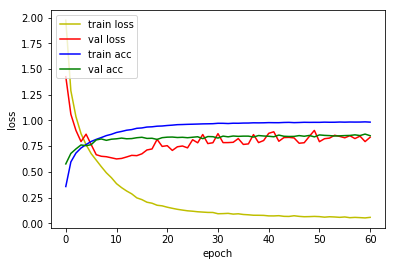

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.7217 - acc: 0.7859
Loss: 0.7216717330218599 Accuracy: 0.78587747

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0485 - acc: 0.3290
Epoch 00001: val_loss improved from inf to 1.43146, saving model to model/checkpoint/1D_CNN_custom_4_DO_6_conv_checkpoint/001-1.4315.hdf5
36805/36805 [==============================] - 278s 8ms/sample - loss: 2.0484 - acc: 0.3291 - val_loss: 1.4315 - val_acc: 0.5539
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4131 - acc: 0.5450
Epoch 00002: val_loss improved from 1.43146 to 1.10443, saving model to model/checkpoint/1D_CNN_custom_4_DO_6_conv_checkpoint/002-1.1044.hdf5
36805/36805 [==============================] - 276s 8ms/sample - loss: 1.4130 - acc: 0.5450 - val_loss: 1.1044 - val_acc: 0.6671
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1326 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.1747 - acc: 0.9423
Epoch 00025: val_loss did not improve from 0.34723
36805/36805 [==============================] - 276s 8ms/sample - loss: 0.1747 - acc: 0.9423 - val_loss: 0.3547 - val_acc: 0.9140
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1658 - acc: 0.9471
Epoch 00026: val_loss did not improve from 0.34723
36805/36805 [==============================] - 276s 8ms/sample - loss: 0.1658 - acc: 0.9471 - val_loss: 0.3526 - val_acc: 0.9106
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1538 - acc: 0.9491
Epoch 00027: val_loss did not improve from 0.34723
36805/36805 [==============================] - 276s 8ms/sample - loss: 0.1538 - acc: 0.9491 - val_loss: 0.3535 - val_acc: 0.9154
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1490 - acc: 0.9523
Epoch 00028: val_loss did not improve from 0.34723
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9771
Epoch 00054: val_loss did not improve from 0.33983
36805/36805 [==============================] - 276s 7ms/sample - loss: 0.0690 - acc: 0.9771 - val_loss: 0.4256 - val_acc: 0.9220
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0630 - acc: 0.9798
Epoch 00055: val_loss did not improve from 0.33983
36805/36805 [==============================] - 276s 7ms/sample - loss: 0.0630 - acc: 0.9798 - val_loss: 0.3893 - val_acc: 0.9273
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9784
Epoch 00056: val_loss did not improve from 0.33983
36805/36805 [==============================] - 276s 7ms/sample - loss: 0.0671 - acc: 0.9784 - val_loss: 0.3653 - val_acc: 0.9278
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0604 - acc: 0.9810
Epoch 00057: val_loss did not improve from 0.33983
36805/36805 [=====================

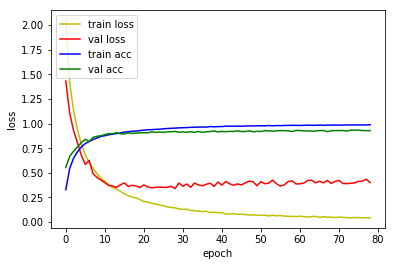

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.3909 - acc: 0.8947
Loss: 0.3909050719141341 Accuracy: 0.89470404

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2766 - acc: 0.2430
Epoch 00001: val_loss improved from inf to 1.59991, saving model to model/checkpoint/1D_CNN_custom_4_DO_7_conv_checkpoint/001-1.5999.hdf5
36805/36805 [==============================] - 281s 8ms/sample - loss: 2.2765 - acc: 0.2430 - val_loss: 1.5999 - val_acc: 0.4969
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5910 - acc: 0.4672
Epoch 00002: val_loss improved from 1.59991 to 1.27806, saving model to model/checkpoint/1D_CNN_custom_4_DO_7_conv_checkpoint/002-1.2781.hdf5
36805/36805 [==============================] - 278s 8ms/sample - loss: 1.5910 - acc: 0.4672 - val_loss: 1.2781 - val_acc: 0.6103
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3277 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.2273 - acc: 0.9277
Epoch 00024: val_loss did not improve from 0.19153
36805/36805 [==============================] - 278s 8ms/sample - loss: 0.2273 - acc: 0.9277 - val_loss: 0.1944 - val_acc: 0.9474
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2120 - acc: 0.9345
Epoch 00025: val_loss did not improve from 0.19153
36805/36805 [==============================] - 278s 8ms/sample - loss: 0.2121 - acc: 0.9344 - val_loss: 0.1959 - val_acc: 0.9420
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2117 - acc: 0.9335
Epoch 00026: val_loss did not improve from 0.19153
36805/36805 [==============================] - 278s 8ms/sample - loss: 0.2117 - acc: 0.9335 - val_loss: 0.1916 - val_acc: 0.9471
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1946 - acc: 0.9386
Epoch 00027: val_loss improved from 0.19153 to 0.18218, saving model to model/checkpo

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9695
Epoch 00053: val_loss did not improve from 0.17194
36805/36805 [==============================] - 277s 8ms/sample - loss: 0.0925 - acc: 0.9695 - val_loss: 0.1901 - val_acc: 0.9557
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0893 - acc: 0.9712
Epoch 00054: val_loss did not improve from 0.17194
36805/36805 [==============================] - 277s 8ms/sample - loss: 0.0892 - acc: 0.9712 - val_loss: 0.1899 - val_acc: 0.9518
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0894 - acc: 0.9695
Epoch 00055: val_loss did not improve from 0.17194
36805/36805 [==============================] - 277s 8ms/sample - loss: 0.0894 - acc: 0.9695 - val_loss: 0.1752 - val_acc: 0.9546
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9705
Epoch 00056: val_loss did not improve from 0.17194
36805/36805 [========

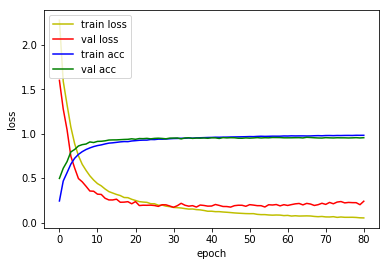

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.2027 - acc: 0.9381
Loss: 0.20269798948386006 Accuracy: 0.93811005

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3179 - acc: 0.2430
Epoch 00001: val_loss improved from inf to 1.56106, saving model to model/checkpoint/1D_CNN_custom_4_DO_8_conv_checkpoint/001-1.5611.hdf5
36805/36805 [==============================] - 281s 8ms/sample - loss: 2.3178 - acc: 0.2430 - val_loss: 1.5611 - val_acc: 0.5222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5814 - acc: 0.4807
Epoch 00002: val_loss improved from 1.56106 to 1.12763, saving model to model/checkpoint/1D_CNN_custom_4_DO_8_conv_checkpoint/002-1.1276.hdf5
36805/36805 [==============================] - 278s 8ms/sample - loss: 1.5815 - acc: 0.4807 - val_loss: 1.1276 - val_acc: 0.6546
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2313 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1986 - acc: 0.9355
Epoch 00023: val_loss did not improve from 0.14292
36805/36805 [==============================] - 278s 8ms/sample - loss: 0.1986 - acc: 0.9355 - val_loss: 0.1489 - val_acc: 0.9553
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1982 - acc: 0.9368
Epoch 00024: val_loss improved from 0.14292 to 0.13391, saving model to model/checkpoint/1D_CNN_custom_4_DO_8_conv_checkpoint/024-0.1339.hdf5
36805/36805 [==============================] - 278s 8ms/sample - loss: 0.1981 - acc: 0.9368 - val_loss: 0.1339 - val_acc: 0.9581
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9406
Epoch 00025: val_loss improved from 0.13391 to 0.13162, saving model to model/checkpoint/1D_CNN_custom_4_DO_8_conv_checkpoint/025-0.1316.hdf5
36805/36805 [==============================] - 278s 8ms/sample - loss: 0.1852 - acc: 0.9406 - val_loss: 0.1316 - val_acc: 0.9599


36800/36805 [============================>.] - ETA: 0s - loss: 0.0921 - acc: 0.9687
Epoch 00050: val_loss did not improve from 0.11717
36805/36805 [==============================] - 277s 8ms/sample - loss: 0.0921 - acc: 0.9687 - val_loss: 0.1190 - val_acc: 0.9655
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0871 - acc: 0.9707
Epoch 00051: val_loss did not improve from 0.11717
36805/36805 [==============================] - 277s 8ms/sample - loss: 0.0871 - acc: 0.9707 - val_loss: 0.1239 - val_acc: 0.9651
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0875 - acc: 0.9705
Epoch 00052: val_loss did not improve from 0.11717
36805/36805 [==============================] - 277s 8ms/sample - loss: 0.0875 - acc: 0.9705 - val_loss: 0.1269 - val_acc: 0.9667
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0811 - acc: 0.9721
Epoch 00053: val_loss did not improve from 0.11717
36805/36805 [=====================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9817
Epoch 00080: val_loss did not improve from 0.11717
36805/36805 [==============================] - 276s 8ms/sample - loss: 0.0517 - acc: 0.9817 - val_loss: 0.1424 - val_acc: 0.9662
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9837
Epoch 00081: val_loss did not improve from 0.11717
36805/36805 [==============================] - 276s 8ms/sample - loss: 0.0491 - acc: 0.9837 - val_loss: 0.1621 - val_acc: 0.9658
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9841
Epoch 00082: val_loss did not improve from 0.11717
36805/36805 [==============================] - 276s 8ms/sample - loss: 0.0480 - acc: 0.9841 - val_loss: 0.1612 - val_acc: 0.9648
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9833
Epoch 00083: val_loss did not improve from 0.11717
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9889
Epoch 00109: val_loss did not improve from 0.11547
36805/36805 [==============================] - 276s 7ms/sample - loss: 0.0341 - acc: 0.9889 - val_loss: 0.1632 - val_acc: 0.9665
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9893
Epoch 00110: val_loss did not improve from 0.11547
36805/36805 [==============================] - 275s 7ms/sample - loss: 0.0317 - acc: 0.9893 - val_loss: 0.1480 - val_acc: 0.9667
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9885
Epoch 00111: val_loss did not improve from 0.11547
36805/36805 [==============================] - 276s 7ms/sample - loss: 0.0345 - acc: 0.9885 - val_loss: 0.1579 - val_acc: 0.9667
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9894
Epoch 00112: val_loss did not improve from 0.11547
36805/36805 [==================

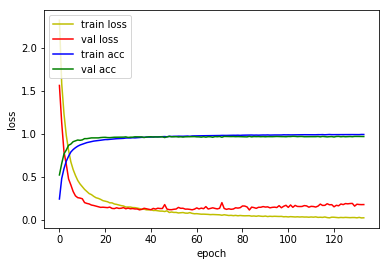

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1697 - acc: 0.9572
Loss: 0.1696946072863146 Accuracy: 0.95721704

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2910 - acc: 0.2552
Epoch 00001: val_loss improved from inf to 1.49640, saving model to model/checkpoint/1D_CNN_custom_4_DO_9_conv_checkpoint/001-1.4964.hdf5
36805/36805 [==============================] - 282s 8ms/sample - loss: 2.2910 - acc: 0.2552 - val_loss: 1.4964 - val_acc: 0.5355
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5337 - acc: 0.5102
Epoch 00002: val_loss improved from 1.49640 to 1.09807, saving model to model/checkpoint/1D_CNN_custom_4_DO_9_conv_checkpoint/002-1.0981.hdf5
36805/36805 [==============================] - 278s 8ms/sample - loss: 1.5336 - acc: 0.5103 - val_loss: 1.0981 - val_acc: 0.6553
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1814 - a

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1556 - acc: 0.9496
Epoch 00025: val_loss improved from 0.14224 to 0.13894, saving model to model/checkpoint/1D_CNN_custom_4_DO_9_conv_checkpoint/025-0.1389.hdf5
36805/36805 [==============================] - 278s 8ms/sample - loss: 0.1556 - acc: 0.9496 - val_loss: 0.1389 - val_acc: 0.9613
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1522 - acc: 0.9515
Epoch 00026: val_loss improved from 0.13894 to 0.13850, saving model to model/checkpoint/1D_CNN_custom_4_DO_9_conv_checkpoint/026-0.1385.hdf5
36805/36805 [==============================] - 278s 8ms/sample - loss: 0.1522 - acc: 0.9515 - val_loss: 0.1385 - val_acc: 0.9581
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1433 - acc: 0.9543
Epoch 00027: val_loss did not improve from 0.13850
36805/36805 [==============================] - 280s 8ms/sample - loss: 0.1433 - acc: 0.9544 - val_loss: 0.1434 - val

36800/36805 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9801
Epoch 00053: val_loss did not improve from 0.12863
36805/36805 [==============================] - 276s 7ms/sample - loss: 0.0596 - acc: 0.9801 - val_loss: 0.1613 - val_acc: 0.9655
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9802
Epoch 00054: val_loss did not improve from 0.12863
36805/36805 [==============================] - 275s 7ms/sample - loss: 0.0608 - acc: 0.9802 - val_loss: 0.1487 - val_acc: 0.9665
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0614 - acc: 0.9800
Epoch 00055: val_loss did not improve from 0.12863
36805/36805 [==============================] - 276s 7ms/sample - loss: 0.0614 - acc: 0.9800 - val_loss: 0.1429 - val_acc: 0.9669
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9823
Epoch 00056: val_loss did not improve from 0.12863
36805/36805 [=====================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9897
Epoch 00083: val_loss did not improve from 0.12863
36805/36805 [==============================] - 274s 7ms/sample - loss: 0.0310 - acc: 0.9897 - val_loss: 0.2383 - val_acc: 0.9648
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9874
Epoch 00084: val_loss did not improve from 0.12863
36805/36805 [==============================] - 275s 7ms/sample - loss: 0.0391 - acc: 0.9874 - val_loss: 0.2023 - val_acc: 0.9595
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9888
Epoch 00085: val_loss did not improve from 0.12863
36805/36805 [==============================] - 275s 7ms/sample - loss: 0.0335 - acc: 0.9888 - val_loss: 0.1892 - val_acc: 0.9665
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9901
Epoch 00086: val_loss did not improve from 0.12863
36805/36805 [========

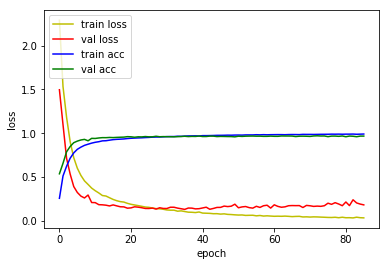

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1870 - acc: 0.9472
Loss: 0.1869683701572079 Accuracy: 0.94724816



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_4_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_4_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 256)         0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 256)         327936    
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 256)         0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 128)         163968    
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 592, 12

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2027 - acc: 0.9381
Loss: 0.20269798948386006 Accuracy: 0.93811005

1D_CNN_custom_4_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 256)         0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 256)         327936    
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 256)         0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 177

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 256)         0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 256)         327936    
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 256)         0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 128)         163968    
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 592, 12

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2254 - acc: 0.9458
Loss: 0.22541982350195927 Accuracy: 0.9457944

1D_CNN_custom_4_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 256)         0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 256)         327936    
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 256)         0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 1777